# Project Title


#### Project Summary


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
from pyspark.sql.functions import isnan, when, count, col ,udf
import datetime as dt
import os
import configparser
from boto.s3.connection import S3Connection
import os

from pyspark.sql.types import StringType , IntegerType, TimestampType, DateType,DoubleType

from pyspark.sql.types import StructType, StructField


In [4]:
#spark version
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"

In [5]:
#read acess and secert_key
config = configparser.ConfigParser()
config.read('dl.cfg')
AWS_ACCESS_KEY_ID = config['AWS']['AWS_ACCESS_KEY_ID']
AWS_SECRET_ACCESS_KEY = config['AWS']['AWS_SECRET_ACCESS_KEY']
os.environ['AWS_ACCESS_KEY_ID'] =  config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = config['AWS']['AWS_SECRET_ACCESS_KEY']

### Step 1: Scope the Project and Gather Data

#### Scope 
in This Data Engineering Project I will Extract more than data source and ETL by Making Data Modelling and put final table in
destination place
I used pandas to read handle small datasets and pyspark for large datasets
I used S3 storage to save all tables 


#### Describe and Gather Data 

I94 Immigration Data: This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. 

World Temperature Data: This dataset came from Kaggle.

U.S. City Demographic Data: This data comes from OpenSoft.

Airport Code Table: This is a simple table of airport codes and corresponding cities.



In [52]:
# Read in the data here
df=pd.read_csv('immigration_data_sample.csv',index_col=0).reset_index()

In [53]:
df=df.drop(columns=["index"])

df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [54]:
#Know all details about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
cicid       1000 non-null float64
i94yr       1000 non-null float64
i94mon      1000 non-null float64
i94cit      1000 non-null float64
i94res      1000 non-null float64
i94port     1000 non-null object
arrdate     1000 non-null float64
i94mode     1000 non-null float64
i94addr     941 non-null object
depdate     951 non-null float64
i94bir      1000 non-null float64
i94visa     1000 non-null float64
count       1000 non-null float64
dtadfile    1000 non-null int64
visapost    382 non-null object
occup       4 non-null object
entdepa     1000 non-null object
entdepd     954 non-null object
entdepu     0 non-null float64
matflag     954 non-null object
biryear     1000 non-null float64
dtaddto     1000 non-null object
gender      859 non-null object
insnum      35 non-null float64
airline     967 non-null object
admnum      1000 non-null float64
fltno       992 non-null object
visat

In [55]:
#Specify columns that have many columns
df_null=pd.DataFrame(df.isnull().sum()).reset_index()
df_null.columns=["Columns","Counts"]
df_null[df_null["Counts"]>500]

,Columns,Counts
14,visapost,618
15,occup,996
18,entdepu,1000
23,insnum,965


In [56]:

df['i94yr'].value_counts()

2016.0    1000
Name: i94yr, dtype: int64

In [6]:
#create spark_session

from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .config("spark.jars.repositories", "https://repos.spark-packages.org/")\
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0,saurfang:spark-sas7bdat:2.0.0-s_2.11")\
        .config("spark.hadoop.fs.s3a.access.key",AWS_ACCESS_KEY_ID)\
        .config("spark.hadoop.fs.s3a.secret.key",AWS_SECRET_ACCESS_KEY)\
        .enableHiveSupport().getOrCreate()


In [58]:
#show immigration_data 
df_spark=spark.read.parquet("sas_data")
df_spark.show(5)

+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|5748517.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     CA|20582.0|  40.0|    1.0|  1.0|20160430|     SYD| null|      G|      O|   null|      M| 1976.0|10292016|     F|  null|     QF|9.495387003E10|00011|      B1|
|5748518.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     NV|20591.0|  32.0|    1.0|  

In [59]:

#Number of rows and columns
print("Number of Columns",len(df_spark.columns))
print("Number Of Rows",df_spark.count())

Number of Columns 28
Number Of Rows 3096313


In [ ]:
#Know how many nissing data we have
null_Count=df_spark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_spark.columns])
null_Count.show()

In [ ]:
#read Temperature Dat
temp= '../../data2/GlobalLandTemperaturesByCity.csv'
temp_df = pd.read_csv(temp)
temp_df.head()

In [ ]:
temp_df["City"].unique()



In [ ]:
temp_df.isnull().sum()


In [ ]:
#Read us-cities-demographics Data
city_df=pd.read_csv('us-cities-demographics.csv',sep=';')
city_df.head()

In [ ]:
#show data for silver spring city
city_df[city_df["City"]=="Silver Spring"]

In [ ]:

city_df.info()

### Step 2: Explore and Assess the Data
#### Explore the Data 
I Explored data with pandas and pyspark
I used pyspark to process large data in immigration_data and handle sas data.

#### Cleaning Steps
After Exploring data I will handle missing data , duplicated data ,data format,inconsistent data

In [22]:
#process some columns
replace_column = udf(lambda x: 'Air' if x==1.0 else ('Sea' if x==2.0 else ('Land' if x==3.0 else 'Not reported')))
replace_column1 = udf(lambda x: 'Business' if x==1.0 else ('Pleasure' if x==2.0 else  'Student'))
replace_column2= udf(lambda x: 1 if x=="M" else 2)


In [23]:
#process some columns
df_spark=df_spark.withColumn("model",replace_column(df_spark.i94mode))\
                          .withColumn("visa_type",replace_column1(df_spark.i94visa))\
                          .withColumn("person_id",replace_column2(df_spark.gender)) 



In [24]:
# Performing cleaning tasks here
fact_table=df_spark.select(["cicid","i94yr","i94mon","i94cit","i94addr","arrdate","depdate","occup","i94visa","airline","ENTDEPA","i94mode","person_id"])\
                            .withColumnRenamed("cicid","fact_id")\
                            .withColumnRenamed("i94yr","year")\
                            .withColumnRenamed("i94mon","month")\
                            .withColumnRenamed("i94cit","city_code")\
                            .withColumnRenamed("arrdate","arrival_date")\
                            .withColumnRenamed("depdate","departure_date")\
                            .withColumnRenamed("i94addr","state_code")\
                            .withColumnRenamed("arrdate","arrive_date")\
                            .withColumnRenamed("occup","Occupation")\
                            .withColumnRenamed("i94visa","Visa_id")\
                            .withColumnRenamed("airline","airline_code")\
                            .withColumnRenamed("ENTDEPA","flag_id")\
                            .withColumnRenamed("i94mode","model_id")


fact_table.show()




+---------+------+-----+---------+----------+------------+--------------+----------+-------+------------+-------+--------+---------+
|  fact_id|  year|month|city_code|state_code|arrival_date|departure_date|Occupation|Visa_id|airline_code|flag_id|model_id|person_id|
+---------+------+-----+---------+----------+------------+--------------+----------+-------+------------+-------+--------+---------+
|5748517.0|2016.0|  4.0|    245.0|        CA|     20574.0|       20582.0|      null|    1.0|          QF|      G|     1.0|        2|
|5748518.0|2016.0|  4.0|    245.0|        NV|     20574.0|       20591.0|      null|    1.0|          VA|      G|     1.0|        2|
|5748519.0|2016.0|  4.0|    245.0|        WA|     20574.0|       20582.0|      null|    1.0|          DL|      G|     1.0|        1|
|5748520.0|2016.0|  4.0|    245.0|        WA|     20574.0|       20588.0|      null|    1.0|          DL|      G|     1.0|        2|
|5748521.0|2016.0|  4.0|    245.0|        WA|     20574.0|       2058

In [25]:
#Extract airline_dimension
airline_dim=df_spark.select(["airline","admnum","fltno","visatype"])\
                    .withColumnRenamed("airline","airline_code")
airline_dim.show()                           


+------------+--------------+-----+--------+
|airline_code|        admnum|fltno|visatype|
+------------+--------------+-----+--------+
|          QF|9.495387003E10|00011|      B1|
|          VA|9.495562283E10|00007|      B1|
|          DL|9.495640653E10|00040|      B1|
|          DL|9.495645143E10|00040|      B1|
|          DL|9.495638813E10|00040|      B1|
|          NZ|9.498180283E10|00010|      B2|
|          NZ|9.497968993E10|00010|      B2|
|          NZ|9.497974673E10|00010|      B2|
|          NZ|9.497324663E10|00028|      B2|
|          NZ|9.501354793E10|00002|      B2|
|          UA|9.493828593E10|01215|      B2|
|          CM|9.501810463E10|00472|      B2|
|          CM|9.492489983E10|00488|      B2|
|          CM|9.492648103E10|00302|      B2|
|          CM|9.492629303E10|00302|      B2|
|          CM|9.500640513E10|00430|      B2|
|          CX|9.492476223E10|00872|      B2|
|          UA|9.499463063E10|05574|      B1|
|          UA|9.499447663E10|05574|      B1|
|         

In [26]:
#Extract Visa_dimension
vis_dim=df_spark.select(["i94visa","visa_type","visapost"])\
                .withColumnRenamed("i94visa","Visa_id")
vis_dim.show()

+-------+---------+--------+
|Visa_id|visa_type|visapost|
+-------+---------+--------+
|    1.0| Business|     SYD|
|    1.0| Business|     SYD|
|    1.0| Business|     SYD|
|    1.0| Business|     SYD|
|    1.0| Business|     SYD|
|    2.0| Pleasure|     ACK|
|    2.0| Pleasure|     ACK|
|    2.0| Pleasure|     ACK|
|    2.0| Pleasure|     ACK|
|    2.0| Pleasure|     ACK|
|    2.0| Pleasure|     GUZ|
|    2.0| Pleasure|     GUZ|
|    2.0| Pleasure|     PNM|
|    2.0| Pleasure|     PNM|
|    2.0| Pleasure|     PNM|
|    2.0| Pleasure|     PNM|
|    2.0| Pleasure|     HNK|
|    1.0| Business|     GUZ|
|    1.0| Business|     GUZ|
|    2.0| Pleasure|     SHG|
+-------+---------+--------+
only showing top 20 rows



In [27]:
#Extract Flag_dimension
Flag_dimm=df_spark.select(["ENTDEPA","ENTDEPD","ENTDEPU","MATFLAG"])\
                .withColumnRenamed("ENTDEPA","flag_id")\
                .withColumnRenamed("ENTDEPD","Departure_Flag")\
                .withColumnRenamed("ENTDEPU","Update_Flag")\
                .withColumnRenamed("MATFLAG","Match_Flag")


Flag_dimm.show()


+-------+--------------+-----------+----------+
|flag_id|Departure_Flag|Update_Flag|Match_Flag|
+-------+--------------+-----------+----------+
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|             O|       null|         M|
|      G|          null|       null|      null|
|      G|             O|       null|    

In [28]:
#Person Dimmension
Person_dimm=df_spark.select(['biryear', 'gender', 'person_id'])\
                .withColumnRenamed("biryear","Birth_Year")
           
Person_dimm.show()

+----------+------+---------+
|Birth_Year|gender|person_id|
+----------+------+---------+
|    1976.0|     F|        2|
|    1984.0|     F|        2|
|    1987.0|     M|        1|
|    1987.0|     F|        2|
|    1988.0|     M|        1|
|    1959.0|     M|        1|
|    1950.0|     F|        2|
|    1975.0|     F|        2|
|    1989.0|     M|        1|
|    1990.0|     F|        2|
|    1972.0|     M|        1|
|    1977.0|     M|        1|
|    1978.0|     M|        1|
|    1960.0|     F|        2|
|    1978.0|     M|        1|
|    1963.0|     F|        2|
|    1932.0|     F|        2|
|    1973.0|     M|        1|
|    1986.0|     F|        2|
|    1982.0|     M|        1|
+----------+------+---------+
only showing top 20 rows



In [32]:
#Model Dimmension
model_dimm=df_spark.select(["i94mode","Model"])\
                .withColumnRenamed("i94mode","model_id")
           
model_dimm.show()

+--------+-----+
|model_id|Model|
+--------+-----+
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
|     1.0|  Air|
+--------+-----+
only showing top 20 rows



In [33]:
city_df.columns

Index(['City', 'State', 'Median Age', 'Male Population', 'Female Population',
       'Total Population', 'Number of Veterans', 'Foreign-born',
       'Average Household Size', 'State Code', 'Race', 'Count'],
      dtype='object')

In [34]:
state_dimm=city_df[["City","State","State Code","Race"]]
state_dimm.columns=["City","State","state_code","Race"]
state_dimm.head()

,City,State,state_code,Race
0,Silver Spring,Maryland,MD,Hispanic or Latino
1,Quincy,Massachusetts,MA,White
2,Hoover,Alabama,AL,Asian
3,Rancho Cucamonga,California,CA,Black or African-American
4,Newark,New Jersey,NJ,White


In [35]:
pop_stats_dimm=city_df[['Median Age', 'Male Population', 'Female Population',
       'Total Population', 'Number of Veterans', 'Foreign-born',
       'Average Household Size', 'State Code']]
pop_stats_dimm.columns=['Median_Age', 'Male_Population', 'Female_Population',
       'Total_Population', 'Number_Veterans', 'Foreign-born',
       'Average_Household Size', 'State_Code']
pop_stats_dimm.head()

,Median_Age,Male_Population,Female_Population,Total_Population,Number_Veterans,Foreign-born,Average_Household Size,State_Code
0,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD
1,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA
2,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL
3,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA
4,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ


In [36]:
temp_dimm=temp_df[["dt","AverageTemperature","AverageTemperatureUncertainty","City","Country"]]
temp_dimm.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country
0,1743-11-01,6.068,1.737,Århus,Denmark
1,1743-12-01,NaN,NaN,Århus,Denmark
2,1744-01-01,NaN,NaN,Århus,Denmark
3,1744-02-01,NaN,NaN,Århus,Denmark
4,1744-03-01,NaN,NaN,Århus,Denmark


### Cleaning_Data

In [37]:
#function to specify percent of missing data
def percent_data(data):
    missing=data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns])
    num_of_data=data.count()
    missing_df=missing.toPandas()
    return missing_df/num_of_data

In [32]:
#will start by fact_table
percent_data(fact_table)

,fact_id,year,month,city_code,state_code,arrival_date,departure_date,Occupation,Visa_id,airline_code,flag_id,model_id,person_id
0,0.0,0.0,0.0,0.0,0.049282,0.0,0.046009,0.997376,0.0,0.027009,0.000077,0.000077,0.0


In [33]:
#I will drop Occupation and drop all missing data in rest of columns 
fact_table=fact_table.drop("Occupation")
fact_table.show()

+---------+------+-----+---------+----------+------------+--------------+-------+------------+-------+--------+---------+
|  fact_id|  year|month|city_code|state_code|arrival_date|departure_date|Visa_id|airline_code|flag_id|model_id|person_id|
+---------+------+-----+---------+----------+------------+--------------+-------+------------+-------+--------+---------+
|5748517.0|2016.0|  4.0|    245.0|        CA|     20574.0|       20582.0|    1.0|          QF|      G|     1.0|        2|
|5748518.0|2016.0|  4.0|    245.0|        NV|     20574.0|       20591.0|    1.0|          VA|      G|     1.0|        2|
|5748519.0|2016.0|  4.0|    245.0|        WA|     20574.0|       20582.0|    1.0|          DL|      G|     1.0|        1|
|5748520.0|2016.0|  4.0|    245.0|        WA|     20574.0|       20588.0|    1.0|          DL|      G|     1.0|        2|
|5748521.0|2016.0|  4.0|    245.0|        WA|     20574.0|       20588.0|    1.0|          DL|      G|     1.0|        1|
|5748522.0|2016.0|  4.0|

In [34]:
#drop missing data and duplicates
fact_table=fact_table.dropna()\
                    .drop_duplicates()
fact_table.count()

2770081

In [35]:
#expole data types
fact_table.printSchema()

root
 |-- fact_id: double (nullable = true)
 |-- year: double (nullable = true)
 |-- month: double (nullable = true)
 |-- city_code: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- arrival_date: double (nullable = true)
 |-- departure_date: double (nullable = true)
 |-- Visa_id: double (nullable = true)
 |-- airline_code: string (nullable = true)
 |-- flag_id: string (nullable = true)
 |-- model_id: double (nullable = true)
 |-- person_id: string (nullable = true)



In [36]:
percent_data(fact_table)

,fact_id,year,month,city_code,state_code,arrival_date,departure_date,Visa_id,airline_code,flag_id,model_id,person_id
0,0,0,0,0,0,0,0,0,0,0,0,0


### change departure_date and arrival to date format


In [37]:
def convert_to_datetime(date):
    """
    Convert to yyyy-mm-dd format
    
    :return: date in yyyy-mm-dd format
    """   
    if date is not None:
        return pd.Timestamp('1960-1-1')+pd.to_timedelta(date, unit='D')
get_date = udf(convert_to_datetime, DateType())
fact_table=fact_table.withColumn("arrival_date",get_date(fact_table.arrival_date))\
.withColumn("departure_date",get_date(fact_table.departure_date))
  
             

In [38]:
fact_table.show()

+---------+------+-----+---------+----------+------------+--------------+-------+------------+-------+--------+---------+
|  fact_id|  year|month|city_code|state_code|arrival_date|departure_date|Visa_id|airline_code|flag_id|model_id|person_id|
+---------+------+-----+---------+----------+------------+--------------+-------+------------+-------+--------+---------+
|5947593.0|2016.0|  4.0|    252.0|        GU|  2016-04-01|    2016-04-03|    2.0|          UA|      A|     1.0|        1|
|5947701.0|2016.0|  4.0|    252.0|        GU|  2016-04-01|    2016-04-03|    2.0|          UA|      A|     1.0|        1|
|5947713.0|2016.0|  4.0|    252.0|        GU|  2016-04-01|    2016-04-03|    2.0|          UA|      A|     1.0|        1|
|5948013.0|2016.0|  4.0|    252.0|        GU|  2016-04-01|    2016-04-04|    2.0|          UA|      A|     1.0|        1|
|5949725.0|2016.0|  4.0|    252.0|        GU|  2016-04-02|    2016-04-04|    2.0|          UA|      A|     1.0|        1|
|5950712.0|2016.0|  4.0|

In [39]:
fact_table.printSchema()

root
 |-- fact_id: double (nullable = true)
 |-- year: double (nullable = true)
 |-- month: double (nullable = true)
 |-- city_code: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- arrival_date: date (nullable = true)
 |-- departure_date: date (nullable = true)
 |-- Visa_id: double (nullable = true)
 |-- airline_code: string (nullable = true)
 |-- flag_id: string (nullable = true)
 |-- model_id: double (nullable = true)
 |-- person_id: string (nullable = true)



### Cleaning airline Dimension

In [40]:
#print Schema
airline_dim.printSchema()   

root
 |-- airline_code: string (nullable = true)
 |-- admnum: double (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)



In [41]:
#show missing data
percent_data(airline_dim)

,airline_code,admnum,fltno,visatype
0,0.027009,0.0,0.006314,0.0


In [42]:
#drop missing data and duplicates
airline_dim=airline_dim.dropna()\
                    .drop_duplicates()
airline_dim.count()

3011563

In [44]:
percent_data(airline_dim)

,airline_code,admnum,fltno,visatype
0,0,0,0,0


### Cleaning Visa Dimmension Table 

In [45]:
#show missing data
percent_data(vis_dim)

,Visa_id,visa_type,visapost
0,0.0,0.0,0.607577


In [46]:
#drop missing data and duplicates
vis_dim=vis_dim.dropna()\
                    .drop_duplicates()
vis_dim.count()

1212

In [47]:
percent_data(vis_dim)

,Visa_id,visa_type,visapost
0,0,0,0


### Cleaning Flag Dimmension

In [48]:
percent_data(Flag_dimm)

,flag_id,Departure_Flag,Update_Flag,Match_Flag
0,0.000077,0.044708,0.999873,0.044708


In [49]:
#drop Update_Flag
Flag_dimm=Flag_dimm.drop("Update_Flag")

In [50]:
Flag_dimm.show()

+-------+--------------+----------+
|flag_id|Departure_Flag|Match_Flag|
+-------+--------------+----------+
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
|      G|          null|      null|
|      G|             O|         M|
|      G|             O|         M|
|      G|             O|         M|
+-------+--------------+----------+
only showing top 20 rows



In [51]:
#drop missing data and duplicates
Flag_dimm=Flag_dimm.dropna()\
                    .drop_duplicates()
Flag_dimm.count()

84

In [52]:
percent_data(Flag_dimm)

,flag_id,Departure_Flag,Match_Flag
0,0,0,0


In [53]:
#show data Schema
Flag_dimm.printSchema()

root
 |-- flag_id: string (nullable = true)
 |-- Departure_Flag: string (nullable = true)
 |-- Match_Flag: string (nullable = true)



### Cleaning Person dimmesion

In [54]:
percent_data(Person_dimm)

,Birth_Year,gender,person_id
0,0.000259,0.133794,0.0


In [55]:
#drop missing data and duplicates
Person_dimm=Person_dimm.dropna()\
                    .drop_duplicates()
Person_dimm.count()

376

In [56]:
Person_dimm.printSchema()

root
 |-- Birth_Year: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- person_id: string (nullable = true)



### Cleaning model dimension

In [57]:
percent_data(model_dimm)

,model_id,Model
0,0.000077,0.0


In [58]:
model_dimm=model_dimm.dropna()\
                    .drop_duplicates()
model_dimm.count()

4

### Cleaning state Dimension 

In [59]:
#show missing data
state_dimm.isnull().sum()

City          0
State         0
state_code    0
Race          0
dtype: int64

In [60]:
#show all types and details  about data
state_dimm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 4 columns):
City          2891 non-null object
State         2891 non-null object
state_code    2891 non-null object
Race          2891 non-null object
dtypes: object(4)
memory usage: 90.4+ KB


In [61]:
#show duplicated data
state_dimm.duplicated().sum()

0

### Cleaning Population Statistics Dimmension.

In [62]:
#show missing data
pop_stats_dimm.isnull().sum()

Median_Age                 0
Male_Population            3
Female_Population          3
Total_Population           0
Number_Veterans           13
Foreign-born              13
Average_Household Size    16
State_Code                 0
dtype: int64

In [63]:
#drop missing data
pop_stats_dimm.dropna(inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [64]:

pop_stats_dimm.isnull().sum()

Median_Age                0
Male_Population           0
Female_Population         0
Total_Population          0
Number_Veterans           0
Foreign-born              0
Average_Household Size    0
State_Code                0
dtype: int64

In [65]:
#show duplicated data
pop_stats_dimm.duplicated().sum()

2287

In [66]:
#drop duplicated data
pop_stats_dimm.drop_duplicates(inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [67]:
#show more details on data
pop_stats_dimm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588 entries, 0 to 2726
Data columns (total 8 columns):
Median_Age                588 non-null float64
Male_Population           588 non-null float64
Female_Population         588 non-null float64
Total_Population          588 non-null int64
Number_Veterans           588 non-null float64
Foreign-born              588 non-null float64
Average_Household Size    588 non-null float64
State_Code                588 non-null object
dtypes: float64(6), int64(1), object(1)
memory usage: 41.3+ KB


In [68]:
pop_stats_dimm.head()

,Median_Age,Male_Population,Female_Population,Total_Population,Number_Veterans,Foreign-born,Average_Household Size,State_Code
0,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD
1,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA
2,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL
3,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA
4,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ


### Cleaning tempearture Dimmension

In [69]:
#show missing data
missing_data=temp_dimm.isnull().sum().reset_index()
missing_data.columns=["cols","counts"]

In [70]:
temp_dimm.count()[0]

8599212

In [71]:
missing_data["percent_NaN"]=missing_data["counts"]/temp_dimm.count()[0]
missing_data

,cols,counts,percent_NaN
0,dt,0,0.000000
1,AverageTemperature,364130,0.042345
2,AverageTemperatureUncertainty,364130,0.042345
3,City,0,0.000000
4,Country,0,0.000000


In [72]:
#drop missing data
temp_dimm.dropna(inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [73]:
#show duplicated data
pop_stats_dimm.duplicated().sum()

0

In [74]:
#check missing data
pop_stats_dimm.isnull().sum()

Median_Age                0
Male_Population           0
Female_Population         0
Total_Population          0
Number_Veterans           0
Foreign-born              0
Average_Household Size    0
State_Code                0
dtype: int64

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
we will work with star schema for Bi Teams and analytics we will extract some information about immigration and know more analyis about that

issue,I used star schema because easy for all to understand and efficent in query because denormalized model unlike snowflake schema 

that model contains 

fact table->it is about bussiness metrics like sales ,profits,number of employess.

dimension tables that surrounds fact table by keys(which link them):they are context that answer why ,how ,where ,when.

#### 3.2 Mapping Out Data Pipelines
we do ETL Pipline Process:


Extracting data from different sources sas_data,us-cities-demographics.csv,../../data2/GlobalLandTemperaturesByCity.csv

transform process:from spliting fact table ,dimension tables ,cleaning , edit data_types  to get final data for  loading in destination source



Load Process:load final data in s3 storage

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.


### I Created python code to run ETL

### We Created Data Model Above in 

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [7]:
#Extract files path
conn = S3Connection(AWS_ACCESS_KEY_ID ,AWS_SECRET_ACCESS_KEY)
bucket = conn.get_bucket("awssparks195")
folders = bucket.list('', '/')
folder_list=[]
s3_bucket="s3a://awssparks195/"
tables_list=[]
for folder in folders:
    print(folder.name)
    tables_list.append(folder.name)
    folder_list.append(s3_bucket+str(folder.name))

airline_table/
fact_table/
flag_table/
model_table/
person_table/
pop_stats_table/
state_table/
temp_table/
visa_table/


In [8]:
# Perform quality checks here
#read Data
def check_data(spark,paths,tables):
    """
    check data quality for numbers of rows
    """
    for p,t in zip(paths,tables):
        df=spark.read.parquet(p)
        count_df=df.count()
        if count_df<1:
            print("table not have data")
        else:
            print(f"the table {t} has {count_df} rows") 

In [9]:
check_data(spark,folder_list,tables_list)

the table airline_table/ has 966 rows
the table fact_table/ has 880 rows
the table flag_table/ has 29 rows
the table model_table/ has 4 rows
the table person_table/ has 161 rows
the table pop_stats_table/ has 588 rows
the table state_table/ has 2891 rows
the table temp_table/ has 8235082 rows
the table visa_table/ has 140 rows


In [10]:
def check_schema(spark,paths,tables):
    """
    check data quality for numbers of rows
    """
    for p,t in zip(paths,tables):
        df=spark.read.parquet(p)
        schema=df.printSchema()
        print(f"the table {t}\n {schema}") 
        

In [11]:
check_schema(spark,folder_list,tables_list)

root
 |-- airline_code: string (nullable = true)
 |-- admnum: string (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)

the table airline_table/
 None
root
 |-- fact_id: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- city_code: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- arrival_date: string (nullable = true)
 |-- departure_date: string (nullable = true)
 |-- Visa_id: string (nullable = true)
 |-- airline_code: string (nullable = true)
 |-- flag_id: string (nullable = true)
 |-- model_id: string (nullable = true)
 |-- person_id: string (nullable = true)

the table fact_table/
 None
root
 |-- flag_id: string (nullable = true)
 |-- Departure_Flag: string (nullable = true)
 |-- Match_Flag: string (nullable = true)

the table flag_table/
 None
root
 |-- model_id: string (nullable = true)
 |-- Model: string (nullable = true)

the table model_table/
 None
root
 |--

###Change types  for my tables

In [12]:
tables_name=['airline_table',
 'fact_table',
 'flag_table',
 'model_table',
 'person_table',
 'pop_stats_table',
 'state_table',
 'temp_table',
 'visa_table']

In [13]:
#read all tables
airline_table=spark.read.parquet('s3a://awssparks195/airline_table')
fact_table=spark.read.parquet('s3a://awssparks195/fact_table')
flag_table=spark.read.parquet('s3a://awssparks195/flag_table')
model_table=spark.read.parquet('s3a://awssparks195/model_table')
person_table=spark.read.parquet('s3a://awssparks195/person_table')
pop_stats_table=spark.read.parquet('s3a://awssparks195/pop_stats_table')
state_table=spark.read.parquet('s3a://awssparks195/state_table')
temp_table=spark.read.parquet('s3a://awssparks195/temp_table')
visa_table=spark.read.parquet('s3a://awssparks195/visa_table')

In [11]:
model_table.show()

+--------+------------+
|model_id|       Model|
+--------+------------+
|     9.0|Not reported|
|     3.0|        Land|
|     1.0|         Air|
|     2.0|         Sea|
+--------+------------+



In [14]:
#Change data types
#fact_table
fact_table=fact_table.withColumn('fact_id',fact_table["fact_id"].cast(StringType()))\
                    .withColumn('year',fact_table["year"].cast(IntegerType())) \
                    .withColumn('month',fact_table["month"].cast(IntegerType())) \
                    .withColumn('city_code',fact_table["city_code"].cast(StringType())) \
                    .withColumn('state_code',fact_table["state_code"].cast(StringType())) \
                    .withColumn('arrival_date',fact_table["arrival_date"].cast(DateType())) \
                    .withColumn('departure_date',fact_table["departure_date"].cast(DateType())) \
                    .withColumn('Visa_id',fact_table["Visa_id"].cast(StringType())) \
                    .withColumn('airline_code',fact_table["airline_code"].cast(StringType())) \
                    .withColumn('airline_code',fact_table["flag_id"].cast(StringType())) \
                    .withColumn('flag_id',fact_table["model_id"].cast(StringType())) \
                    .withColumn('person_id',fact_table["person_id"].cast(StringType())) \
                    
#flag_table
flag_table=flag_table.withColumn('flag_id',flag_table["flag_id"].cast(StringType()))\
                    .withColumn('Departure_Flag',flag_table["Departure_Flag"].cast(StringType()))\
                    .withColumn('Match_Flag',flag_table["Match_Flag"].cast(StringType()))
#person_table   
person_table=person_table.withColumn('Birth_Year',person_table["Birth_Year"].cast(IntegerType()))\
                         .withColumn('gender',person_table["gender"].cast(StringType()))\
                         .withColumn('person_id',person_table["person_id"].cast(StringType()))
#pop_stats
pop_stats_table=pop_stats_table.withColumn('Median_Age',pop_stats_table["Median_Age"].cast(DoubleType()))\
                                .withColumn('Male_Population',pop_stats_table["Male_Population"].cast(DoubleType()))\
                                .withColumn('Female_Population',pop_stats_table["Female_Population"].cast(DoubleType()))\
                                .withColumn('Total_Population',pop_stats_table["Total_Population"].cast(DoubleType()))\
                                .withColumn('Number_Veterans',pop_stats_table["Number_Veterans"].cast(DoubleType()))\
                                .withColumn('Foreign-born',pop_stats_table["Foreign-born"].cast(DoubleType()))\
                                .withColumn('Average_Household',pop_stats_table["Average_Household"].cast(DoubleType()))\
                                .withColumn('State_Code',pop_stats_table["State_Code"].cast(StringType()))
#temp_table
temp_table=temp_table.withColumn('dt',temp_table["dt"].cast(DateType()))\
                    .withColumn('Avg_Temp',temp_table["Avg_Temp"].cast(DoubleType()))\
                    .withColumn('Avg_Temp_Uncertainty',temp_table["Avg_Temp_Uncertainty"].cast(DoubleType()))\
                    .withColumn('City',temp_table["City"].cast(StringType()))\
                    .withColumn('Country ',temp_table["Country"].cast(StringType()))


#airline_table
airline_table=airline_table.withColumn("airline_code",airline_table["airline_code"]
                                .cast(StringType()))\
                           .withColumn("admnum",airline_table["admnum"].cast(DoubleType()))\
                           .withColumn("fltno",airline_table["fltno"].cast(StringType()))\
                           .withColumn("visatype",airline_table["visatype"].cast(StringType()))

In [13]:
temp_table.printSchema()

root
 |-- dt: date (nullable = true)
 |-- Avg_Temp: double (nullable = true)
 |-- Avg_Temp_Uncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Country : string (nullable = true)



#### Check data count rows 

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

### Fact_table

In [9]:


dict_fact={'Cols':['fact_id',
'year',
'month',
'city_code',
'State_code',
'arrival_date',
'departure_date',
'occupation',
'visa_id',
'airline_code',
'flag_id',
'model_id',
'person_id'],'Features':["Primary Key.",
"4 digit year.",
"1 digit month.",
"3 digit for the country code where the visitor born.",
"State of arrival.FK to State_dimm.,the Arrival Date in the USA.",
"the arrival Date in the USA.",
"the departure Date in the USA."
,"Occupation that will be performed in U.S.",
"FK to visa_dimm"
,"FK to airline_dimm"
,"FK to flag_dimm",
"FK to model_dimm"
,"FK to person_dimm"]}


In [10]:
fact_fdict=pd.DataFrame(dict_fact)
fact_fdict

,Cols,Features
0,fact_id,Primary Key.
1,year,4 digit year.
2,month,1 digit month.
3,city_code,3 digit for the country code where the visitor...
4,State_code,"State of arrival.FK to State_dimm.,the Arrival..."
5,arrival_date,the arrival Date in the USA.
6,departure_date,the departure Date in the USA.
7,occupation,Occupation that will be performed in U.S.
8,visa_id,FK to visa_dimm
9,airline_code,FK to airline_dimm


### airline_dimm

In [11]:
airline_dict=pd.DataFrame({"cols":
                           ['airline_code','adnum','flno','visatype'],
                           "descrption":
                           ["Primary Key","Admission Number","Flight number of Airline used to arrive in U.S.",
                            "Class of admission legally admitting the non-immigrant to temporarily stay in U.S."]})
airline_dict

,cols,descrption
0,airline_code,Primary Key
1,adnum,Admission Number
2,flno,Flight number of Airline used to arrive in U.S.
3,visatype,Class of admission legally admitting the non-i...


### Flag_dimm

In [12]:
flag_dict=pd.DataFrame({'cols':
                        ["flag_id",'Departure_Flag','Update_Flag','Match_Flag'],
                        
                        "Descrption":["admitted or paroled into the U.S .Primary Key","Departed, lost I-94 or is deceased",
                                      "Either apprehended, overstayed, adjusted to perm residence"
                                      ,"Match of arrival and departure records"]
                       
                       })
flag_dict

,cols,Descrption
0,flag_id,admitted or paroled into the U.S .Primary Key
1,Departure_Flag,"Departed, lost I-94 or is deceased"
2,Update_Flag,"Either apprehended, overstayed, adjusted to pe..."
3,Match_Flag,Match of arrival and departure records


### model Dimension 

In [3]:
Model_dimm=pd.DataFrame({"cols":["model_id","Model"],
                         "Descrption":["Primary Key","Model Category consist of 4 values Air Sea Land Not reported"
]})
Model_dimm

,cols,Descrption
0,model_id,Primary Key
1,Model,Model Category consist of 4 values Air Sea Lan...


### State Dimension 

In [3]:
State_dict=pd.DataFrame({"cols":["State_code","City","State","Race"],
                         "Descrption":["Primary Key","City Name","State in US","The Race of Person White , latin etc",
]})
State_dict

,cols,Descrption
0,State_code,Primary Key
1,City,City Name
2,State,State in US
3,Race,"The Race of Person White , latin etc"


### Visa Dimension

In [6]:
Visa_dict=pd.DataFrame({"cols":["Visa_id","visa_type","visa_post"],
                         "Descrption":["Primary Key","Type of Visa like Business ,Pleasure, Student"
                                       ,"Department of Statewhere Visa was issued"
]})
Visa_dict

,cols,Descrption
0,Visa_id,Primary Key
1,visa_type,"Type of Visa like Business ,Pleasure, Student"
2,visa_post,Department of Statewhere Visa was issued


### Person Dimension 

In [7]:
person_dict=pd.DataFrame({"cols":["person_id","gender","BirthYear"],
                         "Descrption":["Primary Key","gender of person male ,female ,etc"
                                       ,"the year of person birth"
]})
person_dict

,cols,Descrption
0,person_id,Primary Key
1,gender,"gender of person male ,female ,etc"
2,BirthYear,the year of person birth


### pops Dimension

In [9]:
pop_dict=pd.DataFrame({"cols":["State_code","Male_Pop","Female_Pop","Total_POp","Number_Vet","Forign_born","Avg_HS_Size"],
                         "Descrption":["Primary Key","num of population for male","num of population for female","total of population"
                                       ,"Number of Veterans","Number of Forign born","Average of Household Size"
]})
pop_dict

,cols,Descrption
0,State_code,Primary Key
1,Male_Pop,num of population for male
2,Female_Pop,num of population for female
3,Total_POp,total of population
4,Number_Vet,Number of Veterans
5,Forign_born,Number of Forign born
6,Avg_HS_Size,Average of Household Size


In [16]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="Screenshot 2023-01-22 004921.png", width=1000, height=600)

### Analysis Data 

#### Step 5: Complete Project Write Up
### * tools and technologies for the project.

1-AWs Cloud(iam users,S3 Stoarge)

2-python(pysaprk,pandas)

### * the data should be updated and why.

 * The data was increased by 100x.
   we can used EMR in AWS that provides managed scaling, and reconfiguring of clusters to handle that updated and size of data
   you may run multiple clusters to deal with multiple users and/or applications.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
   we can used airflow to schedule dashboard daily
 * The database needed to be accessed by 100+ people.
   we can load data and schema in data warehouse and other database server
  

In [15]:
fact_table.createOrReplaceTempView('fact_table')
airline_table.createOrReplaceTempView("airline_table")
person_table.createOrReplaceTempView("person_table")
state_table.createOrReplaceTempView("state_table")

### most gender  of immigration person

In [16]:
sql_stm=spark.sql('''
select p.gender,count(p.gender) gender_count

from fact_table f

inner join

person_table p

on f.person_id=p.person_id
group by  p.gender


''')




In [19]:
sql_stm.show()

+------+------------+
|gender|gender_count|
+------+------------+
|     F|       36656|
|     M|       33280|
|     X|         928|
+------+------------+



### the Top  of immigration  for each State

In [27]:

sql_stm1=spark.sql('''
select s.State,count(*) state_count

from fact_table f

inner join

state_table s

on f.state_code=s.state_code

group by  s.State

order by state_count desc

limit 10


''')

In [28]:
sql_stm1.show()

+-------------+-----------+
|        State|state_count|
+-------------+-----------+
|   California|     104104|
|      Florida|      39960|
|        Texas|      10374|
|     New York|       8262|
|     Illinois|       2366|
|Massachusetts|       1656|
|       Nevada|       1530|
|   Washington|       1190|
|      Georgia|       1045|
|   New Jersey|        969|
+-------------+-----------+



In [34]:
df=sql_stm1.toPandas()

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

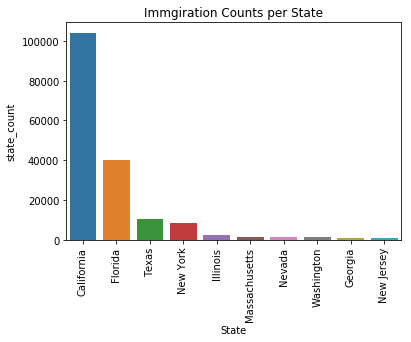

In [37]:
#bar chart for immigration count
sns.barplot(x='State',y='state_count',data=df)
plt.xticks(rotation=90)
plt.title("Immgiration Counts per State")
plt.show()